In [37]:
from RandomForest import RandomForest
from DecisionTree import DecisionTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, precision_score, recall_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random
from preprocessing import *

np.random.seed(42)
random.seed(42)

In [38]:
data = pd.read_csv("diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [39]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### It seems there are no values we need to fill by ourselves since there are no NULL values right? Wrong. While there are no NULL values, there are still values that are missing and they were replaced with 0.

In [40]:
print(data.eq(0).sum(axis=0))

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


#### We can see that there are values that are 0 for most of the columns. However we should also consider if a column can have a 0 value naturally such as 'Pregnancies' (which is the only column that is allowed to have a value 0, other columns having 0 would cause the person to be identified as dead).
#### We will group the columns ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']  by their outcome and fill them with the median of that column as a preprocessing step.

In [41]:
data = replace_zeros_with_median_considering_outcome(data, columns_to_fill=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'])

#### Now we can see what our data looks like using histograms

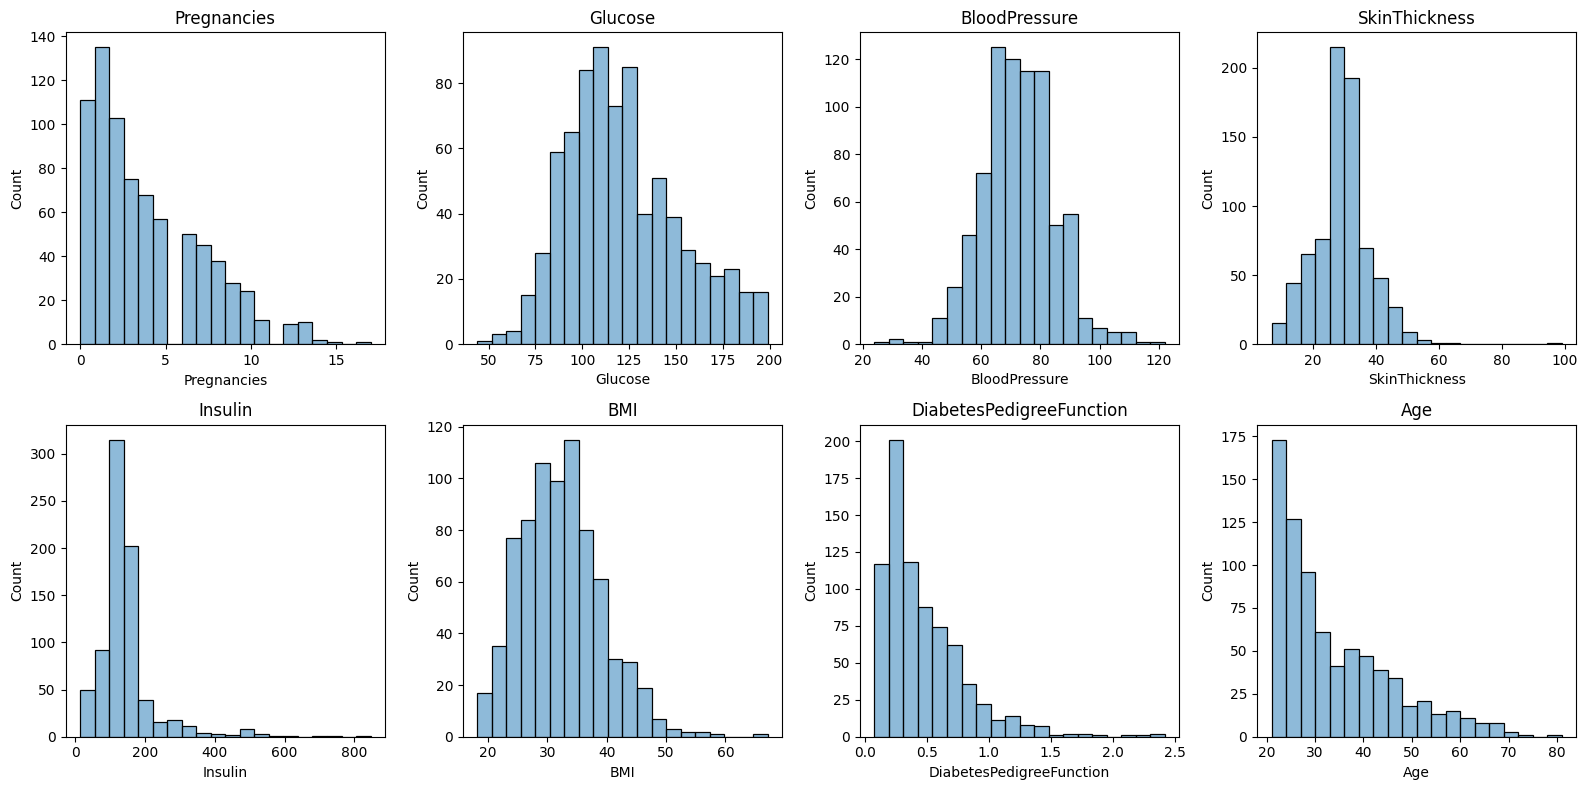

In [42]:
plt.figure(figsize=(16, 8))

counter = 1
for column in data.columns[:-1]:
    plt.subplot(2, 4, counter)
    sns.histplot(data[column], alpha=0.5, bins=20)
    plt.title(column)
    counter += 1

plt.tight_layout()
plt.show()

#### We can see a few outliers in some of the histograms. Lets find them by setting quantile ranges

In [43]:
lower_quantile = 0.03
upper_quantile = 0.97

# Outliers for each column
outliers = data[(data < data.quantile(lower_quantile)) | (data > data.quantile(upper_quantile))]

print("Number of Outliers:")
print(outliers.apply(lambda x: x.count()))


Number of Outliers:
Pregnancies                 23
Glucose                     47
BloodPressure               40
SkinThickness               45
Insulin                     46
BMI                         44
DiabetesPedigreeFunction    48
Age                         21
Outcome                      0
dtype: int64


#### So we have some outliers for every column, We can set them to the lower or upper quartile. However doing this reduced my accuracy and f1-score so I will just leave it as a comment

In [44]:
# data = data.apply(lambda x: x.clip(lower=x.quantile(lower_quantile), upper=x.quantile(upper_quantile)))

#### After the preprocessing steps, we can explore our data. First let's start with a simple correlation matrix

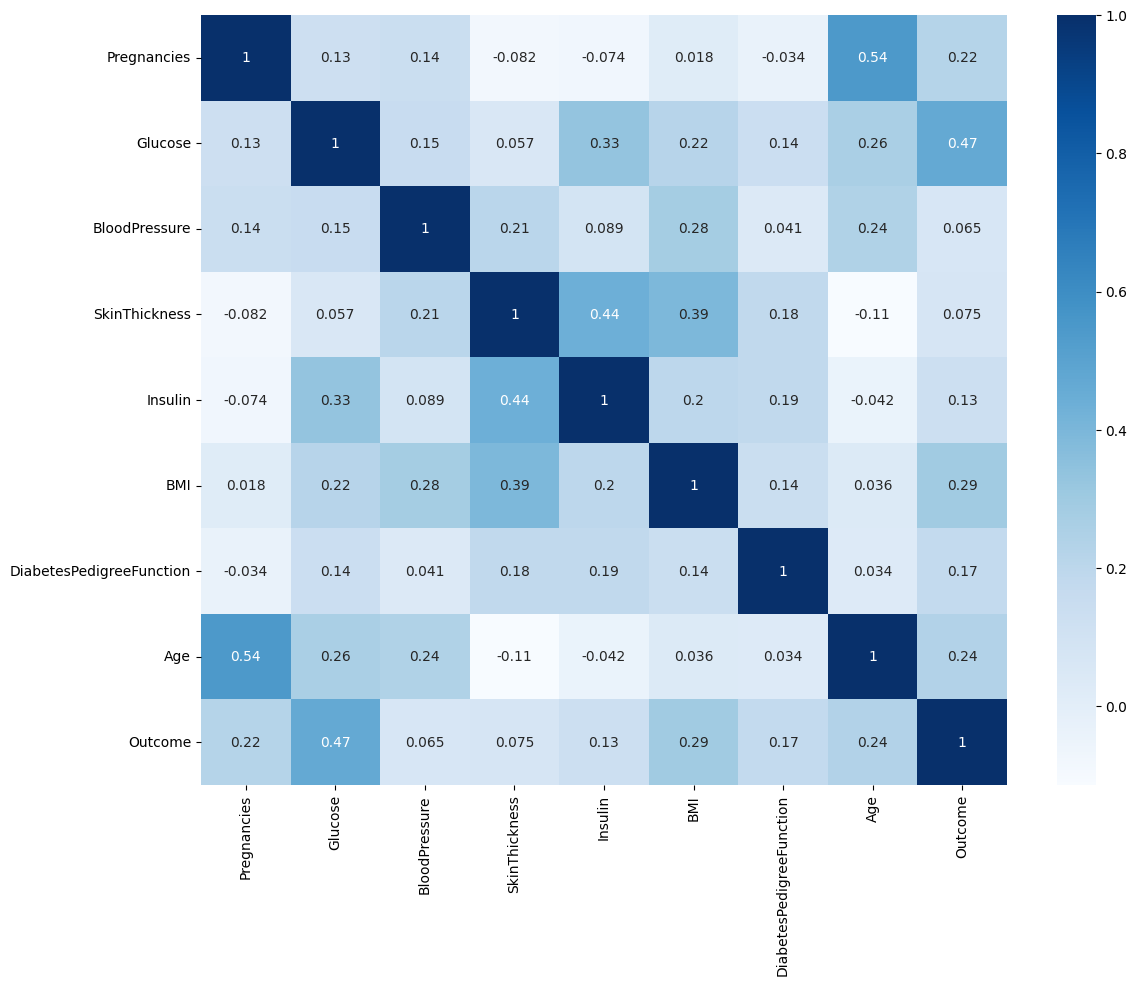

In [4]:
corr = data.corr()
plt.figure(figsize=(13,10))

sns.heatmap(corr, cmap='Blues', annot=True)
plt.show()

In [5]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)


In [8]:
max_depth = 3

# classifier = DecisionTree(max_depth=max_depth , criteria='gini')
classifier = DecisionTree(max_depth=max_depth , criteria='entropy')


classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f"Confusion matrix: \n{classifier.confusion_matrix(y_test, y_pred)}")
accuracy, precision, recall, f1 = classifier.metrics(classifier.confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")


Confusion matrix: 
[[39 16]
 [16 83]]
Accuracy: 0.7922077922077922
Precision: 0.7090909090909091
Recall: 0.7090909090909091
F1: 0.7090909090909091


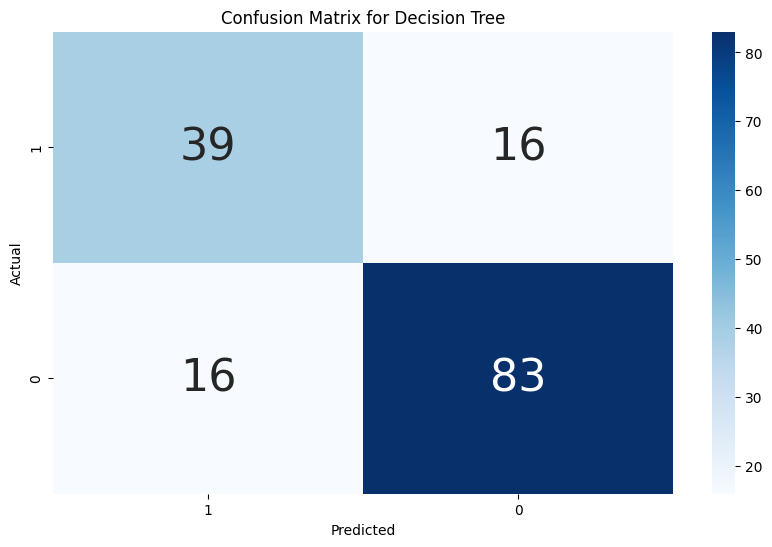

In [7]:
plt.figure(figsize=(10,6))
confusion_matrix = classifier.confusion_matrix(y_test, y_pred)
confusion_matrix[0][0], confusion_matrix[1][1] = confusion_matrix[1][1], confusion_matrix[0][0]
confusion_matrix[0][1], confusion_matrix[1][0] = confusion_matrix[1][0], confusion_matrix[0][1]
sns.heatmap(confusion_matrix, annot=True ,fmt='d', cmap='Blues',annot_kws={"size": 32})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()


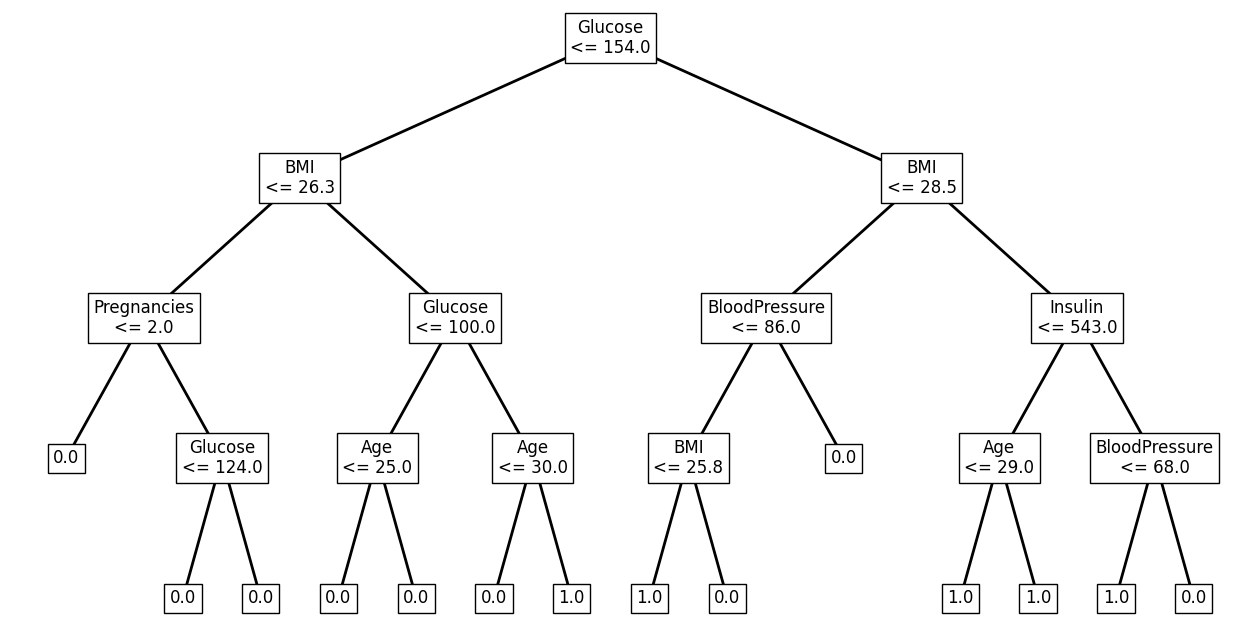

In [8]:
from plot_tree import plot_tree
feature_names = data.columns[:-1]

plt.figure(figsize=(16, 8))
plot_tree(classifier.root, feature_names, max_depth=max_depth)
plt.axis('off')
plt.show()

In [9]:
classifier2 = RandomForest(25, max_depth=3)
classifier2.fit(X_train, y_train)
y_pred = classifier2.predict(X_test)
print(f"Confusion matrix: \n{classifier.confusion_matrix(y_test, y_pred)}")
accuracy, precision, recall, f1 = classifier.metrics(classifier.confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")


Confusion matrix: 
[[28 27]
 [ 8 91]]
Accuracy: 0.7727272727272727
Precision: 0.7777777777777778
Recall: 0.509090909090909
F1: 0.6153846153846153


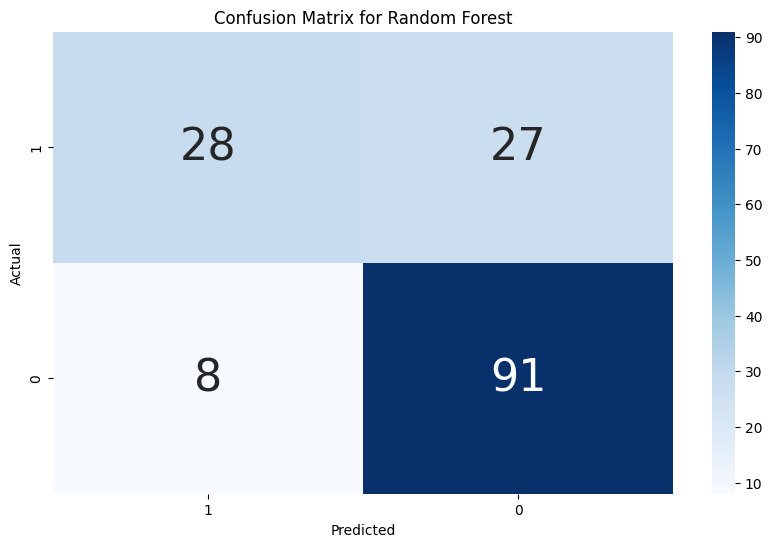

In [10]:

plt.figure(figsize=(10,6))
confusion_matrix = classifier.confusion_matrix(y_test, y_pred)
confusion_matrix[0][0], confusion_matrix[1][1] = confusion_matrix[1][1], confusion_matrix[0][0]
confusion_matrix[0][1], confusion_matrix[1][0] = confusion_matrix[1][0], confusion_matrix[0][1]
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',annot_kws={"size": 32})

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()


